In [22]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
from torch.utils.data import DataLoader

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


In [23]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


(array([111.,   0.,   0., 127.,   0.,   0.,  96.,   0.,   0., 109.]),
 array([769. , 769.3, 769.6, 769.9, 770.2, 770.5, 770.8, 771.1, 771.4,
        771.7, 772. ]),
 <a list of 10 Patch objects>)

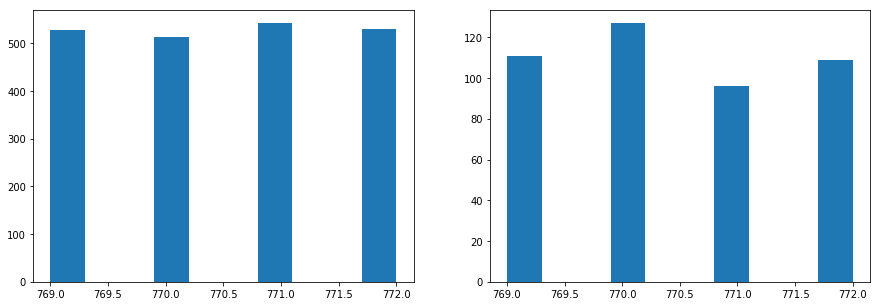

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(y_train_valid)
plt.subplot(1, 2, 2)
plt.hist(y_test)

In [25]:
y_train_valid -= 769
y_test -= 769

In [26]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,X,Y):
        self.X = torch.FloatTensor(X)
        self.Y = torch.LongTensor(Y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index],self.Y[index]

In [27]:
# For subject 1
X_train_valid_1 = X_train_valid[np.where(person_train_valid==0)[0]]
y_train_valid_1 = y_train_valid[np.where(person_train_valid==0)[0]]
X_test_1 = X_test[np.where(person_test==0)[0]]
y_test_1 = y_test[np.where(person_test==0)[0]]

In [28]:
from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_train_valid_1, y_train_valid_1,
                                                              test_size=0.2,shuffle=True)
X_train_1 = X_train_1.transpose(0,2,1)
X_valid_1 = X_valid_1.transpose(0,2,1)
X_test_1 = X_test_1.transpose(0,2,1)
train_set_1 = Dataset(X_train_1,y_train_1)
val_set_1 = Dataset(X_valid_1,y_valid_1)
test_set_1 = Dataset(X_test_1, y_test_1)
train_loader_1 = torch.utils.data.DataLoader(train_set_1,batch_size=32,shuffle=True)
val_loader_1 = torch.utils.data.DataLoader(val_set_1,batch_size=8,shuffle=True)
test_loader_1 = torch.utils.data.DataLoader(test_set_1,batch_size=10,shuffle=True)

In [29]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNClassifier, self).__init__()
        
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, h=None):
        if type(h) == type(None):
            out, hn = self.rnn(x)
        else:
            out, hn = self.rnn(x, h.detach())
        out = self.fc(out[:, -1, :])
        return out

In [30]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        
        self.LSTM = nn.LSTM(input_dim, hidden_dim, batch_first = True, dropout = 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, h=None, c=None):
        if type(h) == type(None) and type(c) == type(None):
            out, (hn, cn) = self.LSTM(x)
        else:
            out, (hn, cn) = self.LSTM(x, h.detach(), c.detach())
        out = self.fc(out[:, -1, :])
        return out

In [31]:
input_dim = 22
hidden_dim = 40
output_dim = 4
model = LSTM(input_dim, hidden_dim, output_dim)
#model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(),lr=0.001)

In [32]:
val_acc_history = []
train_acc_history = []
train_loss_history = []
val_loss_history = []
t0 = time.time()
num_epochs = 30
for epoch in range(num_epochs):
    tstart = time.time()
    for i, data in enumerate(train_loader_1):
        inputs, labels = data
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _,predicted = torch.max(outputs.data, 1)
        train_acc = (predicted == labels).sum().item() / len(labels)
    model.eval()
    train_correct, train_total = 0, 0
    train_loss = 0
    for train_data in train_loader_1:
        train_inputs, train_labels = train_data
        train_outputs = model(train_inputs)
        _, train_predicted = torch.max(train_outputs.data, 1)
        train_total += train_labels.size(0)
        train_correct += (train_predicted == train_labels).sum().item()
        train_loss += criterion(train_outputs, train_labels).item()
    train_acc = train_correct / train_total
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
        
    #pXtrain = model(Xtrain)
    #ptrain = torch.argmax(pXtrain, axis = 1)
    #train_acc = np.mean(ptrain.numpy() == ytrain.numpy())
    #train_accs.append(train_acc)
    #tloss = criterion(pXtrain, ytrain)
    #train_losses.append(tloss.item())
    
    val_correct, val_total = 0, 0
    val_loss = 0
    for val_data in val_loader_1:
        val_images, val_labels = val_data
        val_outputs = model(val_images)
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_total += val_labels.size(0)
        val_correct += (val_predicted == val_labels).sum().item()
        val_loss += criterion(val_outputs, val_labels).item()
    val_acc = val_correct / val_total
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)
    
    #pXval = model(Xval)
    #pval = torch.argmax(pXval, axis = 1)
    #val_acc = np.mean(pval.numpy() == yval.numpy())
    #val_accs.append(val_acc)
    #vloss = criterion(pXval, yval)
    #val_losses.append(vloss.item())
    tend = time.time()
    print('epoch: {:<3d}    time: {:<3.2f}    loss: {:<3.3f}    train acc: {:<1.3f}    val acc: {:<1.3f}'.format(epoch+1, 
            tend - tstart, train_loss, train_acc, val_acc))
time_total = time.time() - t0
print('Total time: {:4.3f} seconds, average time per epoch: {:4.3f}'.format(time_total, time_total / num_epochs))

epoch: 1      time: 6.21    loss: 7.693    train acc: 0.466    val acc: 0.250
epoch: 2      time: 6.85    loss: 7.432    train acc: 0.524    val acc: 0.271
epoch: 3      time: 6.85    loss: 7.185    train acc: 0.577    val acc: 0.229
epoch: 4      time: 6.62    loss: 7.003    train acc: 0.571    val acc: 0.208
epoch: 5      time: 6.55    loss: 6.777    train acc: 0.614    val acc: 0.208
epoch: 6      time: 7.28    loss: 6.607    train acc: 0.667    val acc: 0.188
epoch: 7      time: 6.66    loss: 6.537    train acc: 0.646    val acc: 0.208
epoch: 8      time: 6.38    loss: 6.275    train acc: 0.656    val acc: 0.146
epoch: 9      time: 6.92    loss: 6.059    train acc: 0.741    val acc: 0.125
epoch: 10     time: 8.69    loss: 5.901    train acc: 0.741    val acc: 0.125
epoch: 11     time: 8.54    loss: 5.788    train acc: 0.746    val acc: 0.125
epoch: 12     time: 9.25    loss: 5.681    train acc: 0.772    val acc: 0.146
epoch: 13     time: 10.87    loss: 5.495    train acc: 0.772    

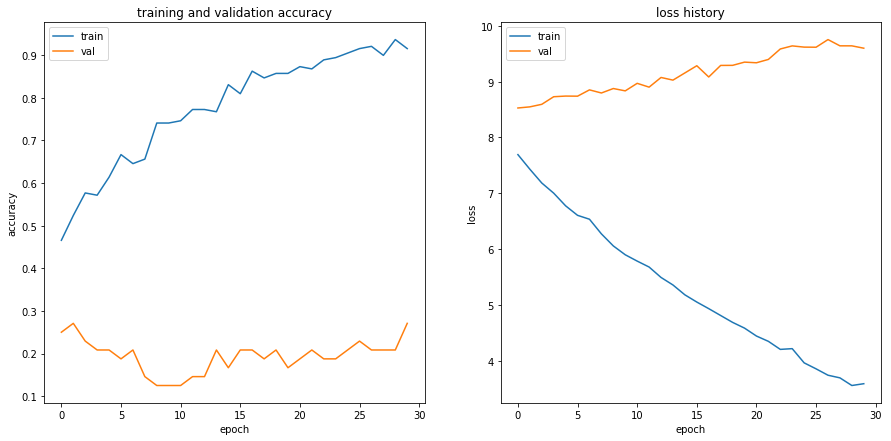

In [33]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.title('training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.subplot(1, 2, 2)
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.title('loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])